In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers

Using TensorFlow backend.


In [2]:
#loading data
DDataFile = './D_VLOS_scaled_mean_mean_alpha6_fft_abs_Frobenius_sphericalWave_B32_U20000.mat'
DData = sio.loadmat(DDataFile)

LocationDataFile = './randLocationU20000VIP.mat'
locationData = sio.loadmat(LocationDataFile)


In [3]:
#preprocessing the data
D_data = np.transpose(DData['D'])
location_data = np.transpose(locationData['location'])
location_data = location_data[:,:2]

#print(D_data.shape)
total, l = D_data.shape
total, d = location_data.shape

train_length = int(np.floor(total * 0.8))

impulses_train = D_data[:train_length, :]
location_train = location_data[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = D_data[train_length:, :]
location_test = location_data[train_length:,:]

20000 16000 (16000, 1024) (16000, 2)


The **best** result for now is use **Three 1024** hidden layers and activation is relu, the actual error distance is 25.8, lr = 0.0001
-  ~~the first layer is 256~~
- ~~decrease lr = 0.00001~~
- ~~*bitch size changes to  32, the avgrage actual error distance is 26.86*~~
- ~~try to sort the data according to the location x and use the half of data to calculate~~
- change the size of validation to 0.1 --> **The best result** 25.45, whose number of the layers is three

- ~~add one more layer 1024, which means there are four 1024 layers --> the result is 28.6~~
- ~~add some dropout(0.2) -> 26.57~~
- add regularizaers {kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)} in threethree Dense layers-> result26.42

In [4]:
#Build the model
model = keras.Sequential()
#keras.layers.normalization.BatchNormalization()
model.add(Dense(1024, activation = 'relu'))    #the hidden layer number 

model.add(Dense(1024, activation = 'relu'))    #the hidden layer number 

model.add(Dense(1024, activation = 'relu'))    #the hidden layer number 

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [5]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.0001) #'Adam'  lr=0.001  #  RMSprop(overfiiting) sgd(overfitting)  Adadelta(overfitting)   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )

#best set: categorical_crossentropy  and sgd, but the loss and acc do not change....

In [6]:
#Train the model, iterating
history = model.fit(impulses_train, location_train,
                    batch_size = 50, # 10,20
                    epochs = 300,
                    verbose = 2,
                    validation_split = 0.1 #0.2
                    #validation_data=(impulses_test, location_test)
                   )


Train on 14400 samples, validate on 1600 samples
Epoch 1/300
 - 13s - loss: 57684.8594 - val_loss: 23348.1520
Epoch 2/300
 - 12s - loss: 8822.9427 - val_loss: 6406.2335
Epoch 3/300
 - 13s - loss: 5363.8267 - val_loss: 4593.3888
Epoch 4/300
 - 12s - loss: 3839.7858 - val_loss: 3328.1604
Epoch 5/300
 - 12s - loss: 2875.4338 - val_loss: 2667.8975
Epoch 6/300
 - 12s - loss: 2402.7515 - val_loss: 2294.3443
Epoch 7/300
 - 13s - loss: 2150.6032 - val_loss: 2106.6567
Epoch 8/300
 - 13s - loss: 1978.0035 - val_loss: 1999.2134
Epoch 9/300
 - 13s - loss: 1871.9728 - val_loss: 1868.2375
Epoch 10/300
 - 13s - loss: 1791.2010 - val_loss: 1851.7970
Epoch 11/300
 - 13s - loss: 1721.2086 - val_loss: 1808.4410
Epoch 12/300
 - 13s - loss: 1672.1735 - val_loss: 1756.9355
Epoch 13/300
 - 13s - loss: 1641.7106 - val_loss: 1670.1432
Epoch 14/300
 - 13s - loss: 1601.1329 - val_loss: 1635.8051
Epoch 15/300
 - 13s - loss: 1558.7370 - val_loss: 1601.5345
Epoch 16/300
 - 13s - loss: 1523.6753 - val_loss: 1567.852

 - 13s - loss: 163.4712 - val_loss: 483.1231
Epoch 140/300
 - 13s - loss: 170.2207 - val_loss: 521.9773
Epoch 141/300
 - 13s - loss: 153.9709 - val_loss: 518.9055
Epoch 142/300
 - 13s - loss: 157.7943 - val_loss: 525.2966
Epoch 143/300
 - 13s - loss: 152.2533 - val_loss: 507.3444
Epoch 144/300
 - 13s - loss: 158.5538 - val_loss: 498.0956
Epoch 145/300
 - 13s - loss: 141.0990 - val_loss: 542.2022
Epoch 146/300
 - 13s - loss: 151.3890 - val_loss: 535.5010
Epoch 147/300
 - 13s - loss: 149.4415 - val_loss: 621.1217
Epoch 148/300
 - 13s - loss: 146.3322 - val_loss: 521.7798
Epoch 149/300
 - 13s - loss: 139.2319 - val_loss: 494.8781
Epoch 150/300
 - 13s - loss: 137.3490 - val_loss: 503.4559
Epoch 151/300
 - 13s - loss: 141.3641 - val_loss: 502.8228
Epoch 152/300
 - 13s - loss: 140.5950 - val_loss: 495.8684
Epoch 153/300
 - 13s - loss: 135.1775 - val_loss: 494.9695
Epoch 154/300
 - 13s - loss: 128.2712 - val_loss: 486.0713
Epoch 155/300
 - 13s - loss: 132.5878 - val_loss: 505.2015
Epoch 156/3

Epoch 280/300
 - 13s - loss: 36.9520 - val_loss: 500.5116
Epoch 281/300
 - 13s - loss: 41.3721 - val_loss: 506.5034
Epoch 282/300
 - 13s - loss: 41.9027 - val_loss: 507.2686
Epoch 283/300
 - 13s - loss: 36.1415 - val_loss: 518.9638
Epoch 284/300
 - 13s - loss: 37.8186 - val_loss: 520.7438
Epoch 285/300
 - 13s - loss: 38.3572 - val_loss: 497.2495
Epoch 286/300
 - 13s - loss: 41.6450 - val_loss: 511.5505
Epoch 287/300
 - 13s - loss: 37.1215 - val_loss: 504.8463
Epoch 288/300
 - 13s - loss: 36.7082 - val_loss: 506.8217
Epoch 289/300
 - 13s - loss: 37.3311 - val_loss: 514.4704
Epoch 290/300
 - 13s - loss: 46.0113 - val_loss: 527.4975
Epoch 291/300
 - 13s - loss: 38.9253 - val_loss: 504.2301
Epoch 292/300
 - 13s - loss: 31.4610 - val_loss: 532.5152
Epoch 293/300
 - 12s - loss: 47.3648 - val_loss: 508.6740
Epoch 294/300
 - 13s - loss: 39.9615 - val_loss: 512.7375
Epoch 295/300
 - 13s - loss: 28.8843 - val_loss: 505.3763
Epoch 296/300
 - 13s - loss: 30.4131 - val_loss: 505.4308
Epoch 297/300


In [7]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

(4000, 2)
(4000, 2)


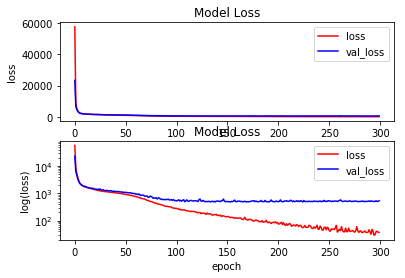

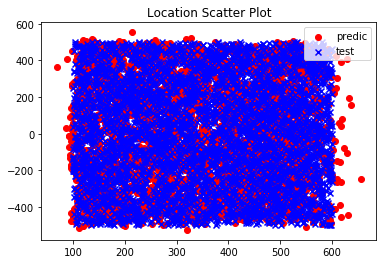

In [8]:
#plot the loss data
import math
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(212)
plt.semilogy(history.history['loss'],'r',label = 'loss')
plt.semilogy(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Location Scatter Plot')
ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
plt.legend()
plt.show()

In [9]:
#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

4000/4000 [==============================] - 1s 144us/step
Test loss & mean_absolute_error:  576.3303532714843


error distance is  25.541219224214583
max error distance is  196.64208788064118
min error distance is  0.3823873181835994


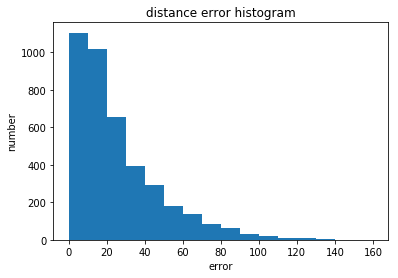

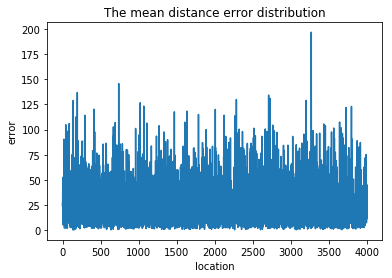

(4000, 1)

In [10]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_abs = np.abs(err)
err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins =  range(0,170,10)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

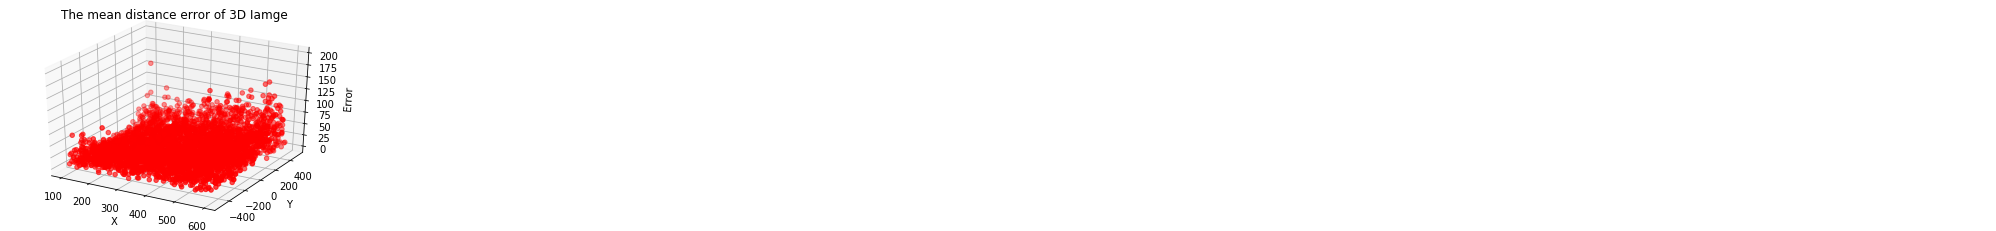

In [12]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

Text(0.5, 1.0, "The mean distance error of 'heat map'")

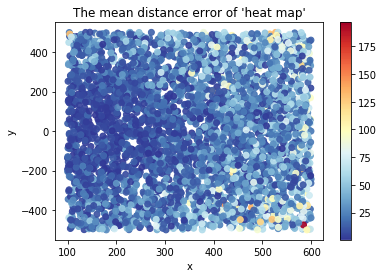

In [13]:
#draw the "heatmap" of error
fig = plt.figure()
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")